[Annotated Transformer Notebook](https://nlp.seas.harvard.edu/annotated-transformer/)

In [1]:
!pip install -q altair==5.5.0 GPUtil==1.4.0

  Preparing metadata (setup.py) ... done


In [2]:
!pip install torch==2.1.0 torchtext==0.16.0 torchdata==0.7.0 numpy==1.26.4 spacy==3.7.2 portalocker==3.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.7 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 76.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 85.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 21.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# !pip install 'portalocker>=2.0.0'

In [4]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 82.2 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: en-core-web-sm
    Found existing installation: en_core_web_sm 3.8.0
    Uninstalling en_core_web_sm-3.8.0:
      Successfully uninstalled en_core_web_sm-3.8.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
from torch.optim.lr_scheduler import LambdaLR
from torchtext.data import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import torchtext.datasets as datasets

import math, copy, time, os
import pandas as pd
import altair as alt
import spacy
import GPUtil
import warnings


# set to False to skip notebook execution
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [6]:
!pip show torchdata

Name: torchdata
Version: 0.7.0
Summary: Composable data loading modules for PyTorch
Home-page: https://github.com/pytorch/data
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: requests, torch, urllib3
Required-by: torchtext, torchtune


In [7]:
def is_interactive_notebook():
    return __name__ == "__main__"

def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)

def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)

class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None

class DummyScheduler:
    def step(self):
        None

# Part 1: Model Architecture

- [Auto-regressive](https://arxiv.org/abs/1308.0850)
- [encoder-decoder structure](https://arxiv.org/pdf/1409.0473)

In [8]:
class EncoderDecoder(nn.Module):
    """
    A standard encoder-decoder architecture. Base for this and maany other models
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        Take in and process masked src and target sequences
        """
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [9]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

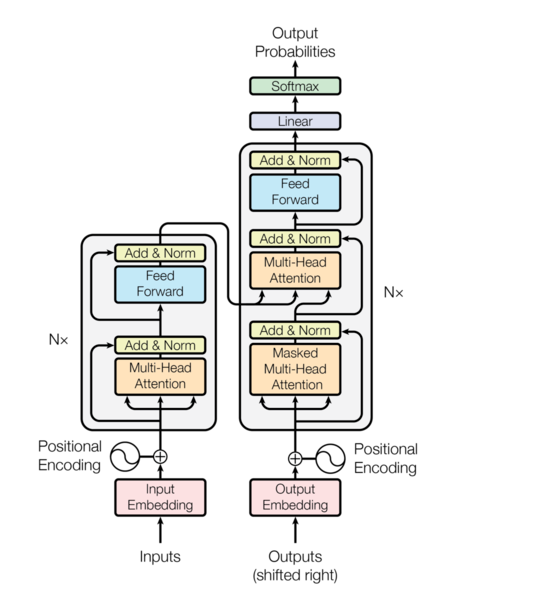

## Encoder and Decoder stack

In [10]:
def clones(module, N):
    """Produces N identical layers
    Args: 
        module: pytorch module
        N: number of layers
    Returns:
        A ModuleList of N independent copies of the given module
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


In [11]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    def forward(self, x, mask):
        "Pass the input and (mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

> Employ a residual connection ([cite](https://arxiv.org/abs/1512.03385)) around each of the two sub-layers, followed by layer normalization ([cite](https://arxiv.org/abs/1607.06450))

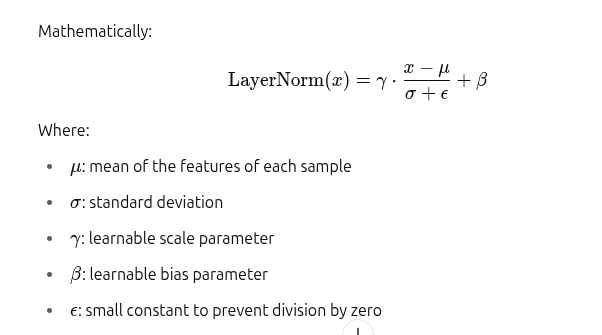

In [12]:
class LayerNorm(nn.Module):
    """
    Construct a layernorm module to normalize features of each input vector independently. 
    It helps stabilize and accelerate the training in RNN and Transformer especially.
    """
    def __init__(self, features, eps=1e-6):
        """
        Args:
            features: the dimension of input vector (d_model)
            eps: small constant to prevent division by Zero
        """
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features)) # this is gamma
        self.b_2 = nn.Parameter(torch.zeros(features)) # this is beta
        self.eps = eps
    def forward(self, x):
        mean = x.mean(axis=-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std+ self.eps) + self.b_2
        

> Apply dropout [cite](http://jmlr.org/papers/v15/srivastava14a.html) to the output of each sub-layer, before it is added to the sub-layer input and normalized

> To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{model} = 512$

In [13]:
class SublayerConnection(nn.Module):
    """
    A Residual connection is followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size) # stable training (size=d_model)
        self.dropout = nn.Dropout(dropout) # prevent overfitting (regularization)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x))) # skip connection for better gradient flow
        

> <div style="text-align: center; font-family: san-serif, arial; font-size: 22px;">Each layer has 2 sublayers, the first is a multi-head self-attention mechanism, and the second is simple, position-wise fully connected feed-forward network.</div>

In [14]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attention and feed-forward network"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn # return a tensor of shape [batch_size, seq_len, d_model]
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
    def forward(self, x, mask):
        """
        Multihead self attetnion then following by the feed forward network
        """
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [15]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking"
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    def forward(self, x, memory, src_mask, tgt_mask):
        """
        Args:
            x: decoder input sequence
            memory: the output of encoder
            src_mask: mask for encoder output
            tgt_mask: mask for decoder input (tensor shape with boolean value: true: pay attention, false: ignore)
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [16]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed-forward"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow right half for right connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x,m,m,src_mask))
        return self.sublayer[2](x, self.feed_forward)

> <div style="text-align: center; font-family: san-serif, arial; font-size: 22px;">Modify the self-attention su-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with the fact that the output embeddinbgs are offset by one position, ensures that the predictions for position i can depond only on the known outputs at positions less than i.</div>

In [17]:
def subsequent_mask(size):
    "Mask out subsequent positions"
    attn_shape = (1, size, size) # 1 batch x "size" query positions x "size" key positions
    # torch.triu  zeros out the elments below and those lie on the main diagonal
    # diagonal will determine whether the diagon element will be zeros out or not
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return subsequent_mask == 0

In [18]:
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                    "Window": y, # y=key: window position: the token being lokking at
                    "Masking": x, # x=query :maskingposition: the token currently produce attention
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q",
            scale=alt.Scale(scheme='viridis')),
        )
        .interactive()
    )

show_example(example_mask)

alt.Chart(...)

## Attention

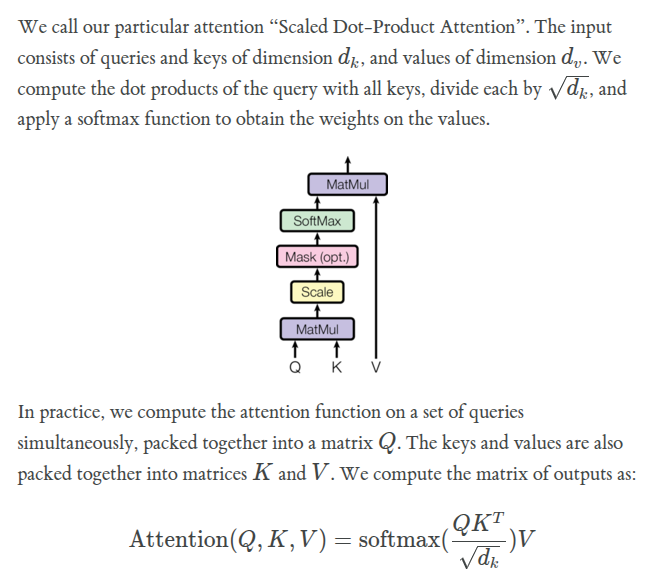

In [19]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute the scaled dot product attention"
    d_k = query.size(-1)
    similarity_scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) 
    if mask is not None:
        # mask multi-head attention in decoder layer
        similarity_scores = similarity_scores.masked_fill(mask == 0, 1e-9)
    p_attn = similarity_scores.softmax(dim=-1) # probabilities attention
    if dropout is not None:
        p_attn = dropout(p_attn)
    weighted_sum = torch.matmul(p_attn, value)
    return weighted_sum, p_attn

## Multihead Attention (figure 2)

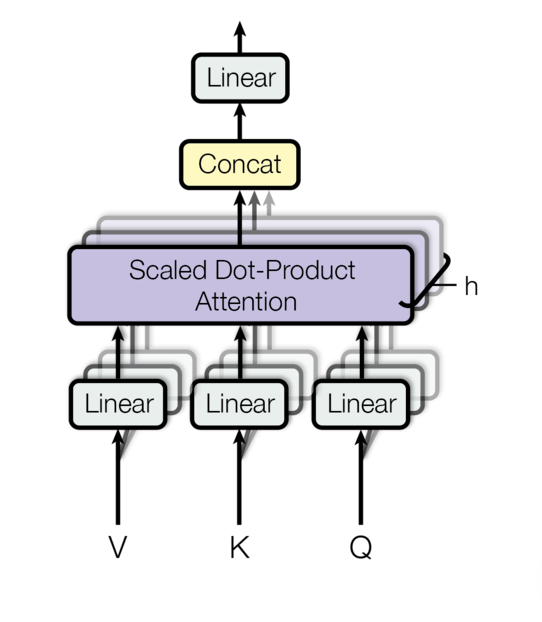

In [20]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads"
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.attn = None  # stores attention weights, not a function
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.dropout = nn.Dropout(p=dropout)  # ❗️you had a typo: 'sekf.droput'

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2 (Vaswani et al. 2017)"

        # mask.shape = [batch, query_len, key_len]
        # attention score shape after unsqueeze = [batch, heads, query_len, key_len]
        if mask is not None:
            # Apply the same mask to all heads
            mask = mask.unsqueeze(1)  # → [batch, 1, query_len, key_len]

        nbatches = query.size(0)

        # 1) Apply linear projection to Q, K, V
        query, key, value = [
            # lin(x): [batch, seq_len, d_model]
            # reshape to [batch, seq_len, heads, d_k]
            # then transpose to [batch, heads, seq_len, d_k]
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply scaled dot-product attention on projected Q, K, V
        # returns: x [batch, heads, query_len, d_k], self.attn [batch, heads, query_len, key_len]
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) Concatenate attention output heads and apply final linear layer
        x = (
            x.transpose(1, 2)               # → [batch, query_len, heads, d_k]
             .contiguous()                  # make memory layout suitable for view
             .view(nbatches, -1, self.h * self.d_k)  # → [batch, query_len, d_model]
        )

        # free up memory (optional)
        del query
        del key
        del value

        # apply the final linear layer to combine all heads
        return self.linears[-1](x)


## Position-wise Feed-forward Networks

In [21]:
class PositionwiseFeedForward(nn.Module):
    "Implements FNN equation"
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))


## EMbedding and softmax
> <div style="text-align:center; font-size: 20px; font-family: san-serif, arial;";>Similarly to other sequence transudction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{model}$. We also use the usual learned linear transformatin and softmax function to convert the decoder output to predicted next-token probabilites. In our model, we share the same weight matrix between the two embedding layers(input embeddings and output embeddings from the decoder) and the pre softmax linear transformations. </div>

In [22]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    def forward(self, x):
        # X.SHAPE = [BATCH SIZE, SEQ_LEN]
        # simply indexing (just like look-up table)
        # self.lut(x) returns [batch_size, seq_len, d_model]
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding
Take the two following sentences as examples:
- Red car is fast
- Big dog runs fast

Both position 0 and 1 in those examples have similar positional difference patterns (position 1 is a noun , positio 0 is a adj, modify the noun). The model can generalize to this:

“Word at position i often describes the word at position i+1”
→ even if i = 0 or 10 or 100

So the actual position doesn’t matter — the relative distance does.

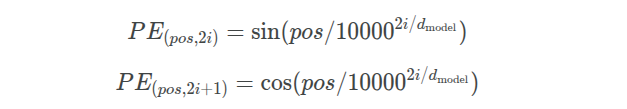

In [23]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1) # a column vector
        # 10000 ^ (2i/d_model) = exp(log(10000^(2i/d_model))) = exp(2i/model *log(10000)) = exp (2i * log(10000) / d_model)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        # positve shape = [max_len, 1], div_term shape = [d_model // 2]
        # postive * div_term is broadcasted to [max_len, d_model // 2]
        # which means for each row position i, each even i and odd i dimension was assigned with each sin and cos formula
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # pe shape = [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        "x is a tensor contain token embeddings"
        # x.shape = [batch size, seq_len, d_model]
        # self.pe[:, :x.size(1)] shape = [batch size, seq_len, d_model]
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

<div style="text-align: center; font-family: san-serif, arial; font-size: 22px;">Below the positional encoding will add a sine wave based on position. The frequency and offset of the wave is different for each dimension.</div>

In [24]:
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))
    data = pd.concat([
        pd.DataFrame(
            {
                "embedding": y[0,:, dim],
                "dimension": dim,
                "position": list(range(100))
            }
        )
        for dim in [4, 5, 6, 7]
    ])
    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800, height=500)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )

show_example(example_positional)

alt.Chart(...)

## Full Model

In [25]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters"
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab) # linear + softmax layer
    )
    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model
        

## Inference
> <div style="text-align: center; font-family: san-serif, arial; font-size: 22px;">Here we make a forward step to generate a prediction of the model. We try to use our transformer to memorize the inputs. As you will see the output is randomly generated due to the fact that the model is not trained yet. In the next tutorial we will build the training function and try to train our model to memorize the numbers from 1 to 10.</div>

In [26]:
def inference_test():
    test_model = make_model(src_vocab=11, tgt_vocab=11, N=2)
    test_model.eval() # disable dropout, batch normalization
    src = torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]])
    src_mask = torch.ones(1,1,10) # no padding tokens

    # apply embedding , positional encoding, N encoder-layers 
    # src shape = [batch size, src_len]
    # src mask = [batch size, heads, query len, src_len]
    memory = test_model.encode(src,src_mask) # shape [batch size, src_len, d_model]
    ys = torch.zeros(1,1).type_as(src) # <SOS> token

    for i in range(9):
        # out shape = [batch size, tgt_len, d_model]
        out = test_model.decode(
            memory=memory, src_mask=src_mask, 
            tgt=ys, tgt_mask=subsequent_mask(size=ys.size(1)).type_as(src.data)
        )
        # applying linear + softmax layers
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1) # value, indices
        next_word = next_word.item()
        ys = torch.cat(
            [ys, torch.empty(1,1).type_as(src.data).fill_(next_word)], dim=1
        )
    print(f"Example Untrained Model Prediction: ", ys)


def run_tests():
    for _ in range(10):
        inference_test()

show_example(run_tests)

Example Untrained Model Prediction:  tensor([[0, 6, 6, 6, 6, 6, 6, 6, 6, 3]])
Example Untrained Model Prediction:  tensor([[ 0,  5, 10,  6,  1,  6,  8,  3,  5, 10]])
Example Untrained Model Prediction:  tensor([[ 0, 10, 10,  5,  6,  5,  6,  5,  6,  5]])
Example Untrained Model Prediction:  tensor([[0, 0, 0, 0, 0, 8, 3, 3, 3, 3]])
Example Untrained Model Prediction:  tensor([[0, 1, 6, 0, 1, 6, 0, 1, 4, 6]])
Example Untrained Model Prediction:  tensor([[0, 7, 6, 9, 3, 2, 3, 3, 2, 3]])
Example Untrained Model Prediction:  tensor([[0, 9, 2, 2, 3, 8, 0, 9, 2, 2]])
Example Untrained Model Prediction:  tensor([[0, 9, 9, 9, 9, 6, 5, 5, 5, 5]])
Example Untrained Model Prediction:  tensor([[0, 5, 4, 9, 2, 5, 4, 4, 6, 6]])
Example Untrained Model Prediction:  tensor([[0, 3, 8, 3, 8, 3, 8, 3, 8, 3]])


# Part 2: Model Training

<div style="text-align: center; font-family: san-serif, arial; font-size: 22px;">First we define a batch object that holds the src and target sentences for training, as well as constructing the masks.</div>

## Batches and Masking

In [27]:
class Batch:
    """Object for holding batch of data with mask during training."""
    def __init__(self, src, tgt=None, pad=2): # 2 = <blank>
        self.src = src # [batch size, src_len]
        self.src_mask = (src != pad).unsqueeze(-2) # [batch size, 1, src_len]
        if tgt is not None:
            self.tgt = tgt[:, :-1] # [batch size, tgt_len] shfit right
            self.tgt_y = tgt[:, 1:]
            # print(tgt.shape)
            self.tgt_mask = self.make_std_mask(self.tgt, pad) # arguments: target and mask
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words"
        # print(f"Inside make_std_mask: {tgt.shape}")
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

> <div style="font-family: san-serif, arial; font-size: 18px;">Next we create a generic training and scoring function to keep track of loss. We pass in a generic loss compute function that also handles params updates</div>

## Training loop


In [28]:
class TrainState:
    """Track number of steps, examples and tokens processed"""
    step: int = 0 # steps in the current epoch
    accum_step: int = 0 # number of gradients accumulation steps
    samples: int = 0 # number of examples used
    tokens: int = 0 # total number of tokens processed


In [29]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
        # loss: scalar total loss(multiplied by ntokens)
        # loss_node: a Pytorch tensor requiring gradient (used for backward)
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()
        
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
            % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

## Training Data and Batching
> <div style="font-family: san-serif, arial; font-size: 18px;">Sentence pairs were batched together by aproximate sequence length. Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens</div>

## Hardware and Scedule
> <div style="font-family: san-serif, arial; font-size: 18px;">The paper say that: We trained the base models for a total of 100,000 steps or 12 hours. For our big models, step time was 1.0 seconds. The big models were trained for 300,000 steps (3.5 days)</div>

## Optimizer
> <div style="font-family: san-serif, arial; font-size: 18px;">We used the Adam optimizer for this training</div>

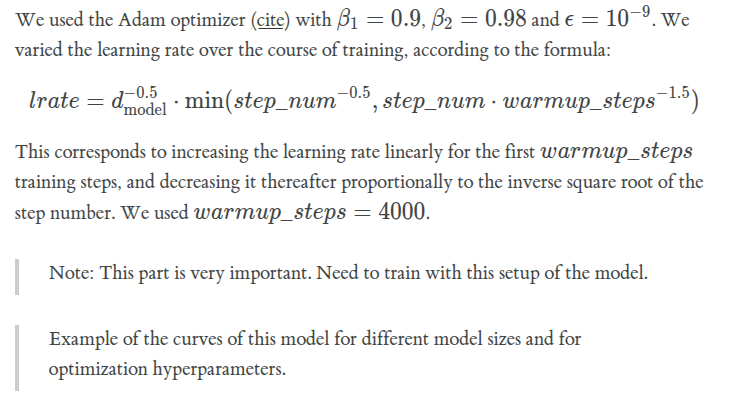

In [30]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function to avoid
    zero raising to negative power
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min (step **  (-0.5), step * warmup ** (-1.5))
    )

In [31]:
def example_learning_schedule():
    opts = [
        [512, 1, 4000], # example 1: model size, factor, warmup
        [512, 1, 8000], # example 2
        [256, 1, 4000], # example 3
    ]
    dummy_model = torch.nn.Linear(1, 1)
    learning_rates = []

    # we have 3 examples in opts list
    for idx, example in enumerate(opts):
        # run 20,000 epochs for each example
        optimizer = torch.optim.Adam(
            dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
        )
        lr_scheduler = LambdaLR(
            optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
        )
        tmp = []
        # take 20,000 dummy trainiing steps, save the learning rate at each step
        for step in range(20000):
            tmp.append(optimizer.param_groups[0]["lr"])
            optimizer.step()
            lr_scheduler.step()
        learning_rates.append(tmp)

    learning_rates = torch.tensor(learning_rates)

    # enable altairs to handle more than 5000 rows
    alt.data_transformers.disable_max_rows()
    opts_data = pd.concat([
        pd.DataFrame(
            {
                "Learning Rate": learning_rates[warmup_idx, :],
                "model_size_warmup": ["512:4000", "512:8000", "256:4000"][warmup_idx],
                "step": range(20000),
            }
        )
        for warmup_idx in [0, 1, 2]
    ])
    return (
        alt.Chart(opts_data)
        .mark_line()
        .properties(width=600)
        .encode(x="step", y="Learning Rate", color="model_size_warmup:N")
        .interactive()
    )

(example_learning_schedule())
    

alt.Chart(...)

## Regularization

### Label Smoothing

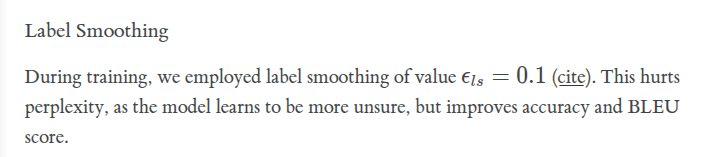


> > <div style="font-family: san-serif, arial; font-size: 18px;">We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has confidence of the correct word and the rest of the smoothing mass distributed throughout the vocabulary.</div>

In [32]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing"
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        # x shape = [batch size * seq_len, vocab size], the same shape with true_dist
        # target shape = [batch_size * seq_len]
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

> <div style="font-family: san-serif, arial; font-size: 18px;">Here we can see an example of how the mass is distributed to the words based on confidence</div>

In [33]:
def example_label_smoothing():
    crit = LabelSmoothing(5, 0, 0.4)
    predict = torch.FloatTensor([
        [0, 0.2, 0.7, 0.1, 0],
        [0, 0.2, 0.7, 0.1, 0],
        [0, 0.2, 0.7, 0.1, 0],
        [0, 0.2, 0.7, 0.1, 0],
        [0, 0.2, 0.7, 0.1, 0],
    ])
    crit(x=predict.log(), target=torch.LongTensor([2, 1, 0, 3, 3]))
    LS_data = pd.concat(
        [
            pd.DataFrame({
                "target distribution": crit.true_dist[x, y].flatten(),
                "columns": y,
                "rows": x,
            })
            for y in range(5)
            for x in range(5)
        ]
    )

    return (
    alt.Chart(LS_data)
    .mark_rect(color="Blue", opacity=1)
    .properties(height=500, width=500)
    .encode(
        alt.X("columns:O", title=None),
        alt.Y("rows:O", title=None),
        alt.Color(
            "target distribution:Q", scale=alt.Scale(scheme="viridis")
        ),
    )
    .interactive())

show_example(example_label_smoothing)

alt.Chart(...)

In [34]:
def loss(x, crit):
    d = x + 3 * 1
    predict = torch.FloatTensor([[1/d, x/d, 1/d, 1/d, 1/d]])
    predict = predict / predict.sum()
    return crit(predict.log(), torch.LongTensor([1])).data

def penalization_visualization():
    crit = LabelSmoothing(5, 0, 0.1)
    loss_data = pd.DataFrame(
        {
            "Loss": [loss(x, crit) for x in range(1, 100)],
            "Steps": list(range(99)),
        }
    ).astype("float")
    return (
        alt.Chart(loss_data)
        .mark_line()
        .properties(width=350)
        .encode(
            x="Steps",
            y="Loss",
        )
        .interactive()
    )

show_example(penalization_visualization)

alt.Chart(...)

## A First Example
> <div style="font-family: san-serif, arial; font-weight: 20px;"> We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols.</div>

## Synthetic Data

In [35]:
def data_gen(V, batch_size, nbatches):
    "Generate random data fora src-tgt copy task"
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        # src = data.requires_grad(False).clone().detach()
        # tgt = data.requires_grad(False).clone().detach()
        src = data.clone()
        tgt = data.clone()
        yield Batch(src, tgt, 0)

dg = data_gen(V=11, batch_size=2, nbatches=3)
for idx, batch in enumerate(dg):
    print(batch.src)
    print(batch.tgt)

tensor([[ 1,  3,  3,  4,  1,  7,  7,  8,  7,  4],
        [ 1,  7,  9,  6,  3, 10, 10, 10,  7,  4]])
tensor([[ 1,  3,  3,  4,  1,  7,  7,  8,  7],
        [ 1,  7,  9,  6,  3, 10, 10, 10,  7]])
tensor([[ 1,  5,  8,  5,  9,  7, 10,  5,  7,  1],
        [ 1,  3,  5, 10,  3,  3,  2, 10,  2,  2]])
tensor([[ 1,  5,  8,  5,  9,  7, 10,  5,  7],
        [ 1,  3,  5, 10,  3,  3,  2, 10,  2]])
tensor([[ 1,  6,  7,  4, 10,  8,  1,  9, 10,  3],
        [ 1,  6,  4,  7,  8,  4,  7,  9,  2,  5]])
tensor([[ 1,  6,  7,  4, 10,  8,  1,  9, 10],
        [ 1,  6,  4,  7,  8,  4,  7,  9,  2]])


## Loss Computation

In [36]:
class SimpleLossCompute:
    "A simple loss computeand train function"
    
    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion
        
    def __call__(self, x, y, norm):
        # x shape = [batch size, seq_len, d_model]
        # y shape = [batch size, seq_len ]
        x = self.generator(x)
        # x shape turns to [batch size, seq_len, vocab_size], reshape it to [batch size * seq_len, vocab_size]
        # y shape = [batch size, seq_len]
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

## Greedy Decoding
<div style="font-family: san-serif, arial; font-size: 18px;"> This code predicts a translation using greedy decoding for simplicity</div>

In [37]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    Generates output tokens one at a time, always picking the token with maximum probability at each step.
    Args:
        src: [1, src_len]: a sentence with input token IDs
        src_mask: [1, 1, src_len]: mask to ignore padding in source
        start_symbol: int:  usually <BOS>, first token of input 
    """
    memory = model.encode(src, src_mask) # [1, src_len, d_model] 
    # ys = [[start_token]] shape: [1,1]
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data) # [1, current_tgt_len]
    for i in range(max_len - 1):
        out = model.decode(
            # subsequent_mask shape: [1, current_tgt_len, current_tgt_len]
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        # out shape = [batch size, seq_len, d_model]
        # out[:,-1]: shape [1, d_model]
        # we care only the last generated token's decoder output
        prob = model.generator(out[:, -1])
        _, next_word_tensor = torch.max(prob, dim=1) # (values, indices)
        next_word = next_word_tensor.item()
        ys = torch.cat([
            ys, torch.zeros(1,1).type_as(src.data).fill_(next_word)
        ], dim=1)
    return ys

In [38]:
# train the simple copy task
def example_simple_model():
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = make_model(src_vocab=V, tgt_vocab=V, N=2)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )
    batch_size = 80
    for epoch in range(20):
        model.train()
        run_epoch(
            data_gen(V, batch_size, 20),
            model, SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )
        model.eval()
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )[0]
    model.eval()
    src = torch.LongTensor([[0,1,2,3,4,5,6,7,8,9]])
    max_len = src.shape[1]
    src_mask = torch.ones(1,1,max_len)
    print(greedy_decode(model, src,src_mask, max_len=max_len, start_symbol=0))

# execute_example(example_simple_model)

# Part 3: A Real World Example
> Now we consider a real-world example using he Multi30k German-English Translation Task. This task is much smaller than the WMT Task considered in the paper, but it illustrate the whole system.

## Data Loading
> We will load the dataset using torchtext and spacy for tokenization

In [39]:
def load_tokenizers():
    try:
        spacy_de = spacy.load("de_core_news_sm")
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")
    try:
        spacy_en = spacy.load("en_core_web_sm")
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")
    return spacy_de, spacy_en

def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]

def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

In [40]:
import os
import torch
from torchtext import datasets
from torchtext.vocab import build_vocab_from_iterator
import spacy

def safe_yield_tokens(data_iter, tokenizer, index):
    """Safely yield tokens, handling Unicode errors gracefully"""
    processed_count = 0
    error_count = 0
    
    for item in data_iter:
        try:
            text = item[index]
            # Handle potential encoding issues
            if isinstance(text, bytes):
                text = text.decode('utf-8', errors='ignore')
            elif isinstance(text, str):
                # Clean up text but don't be too aggressive
                text = text.strip()
            
            if text:  # Only process non-empty text
                tokens = tokenizer(text)
                if tokens:  # Only yield if we got tokens
                    yield tokens
                    processed_count += 1
            
        except (UnicodeDecodeError, UnicodeError, AttributeError) as e:
            error_count += 1
            continue
        except Exception as e:
            error_count += 1
            continue
    
    print(f"    Processed: {processed_count}, Errors: {error_count}")


In [41]:
# from torchtext import datasets

# clear_multi30k_cache()
# print(os.path.isfile('/kaggle/working/clean_multi30k_cache/datasets/Multi30k/mmt16_task1_test.tar.gz'))
# print(os.path.isdir('/kaggle/working/clean_multi30k_cache'))
# # Clean download to avoid cache issues
# test_iter = datasets.Multi30k(
#     split='test',
#     language_pair=("de", "en"),
#     root="/kaggle/working/clean_multi30k_cache"
# )

# # Should NOT raise UnicodeDecodeError now
# try:
#     _ = next(iter(test_iter))
# except UnicodeDecodeError as e:
#     print(f"Error: {e}")

In [42]:
# print(os.path.isfile('/kaggle/working/clean_multi30k_cache/datasets/Multi30k/mmt16_task1_test.tar.gz'))

In [43]:
import tarfile
from pathlib import Path

def extract_test_file(tar_path, extract_dir):
    # path example
    # tar_path = "/kaggle/working/clean_multi30k_cache/datasets/Multi30k/mmt16_task1_test.tar.gz"
    # extract_dir = "/kaggle/working/clean_multi30k_cache/extracted"
    Path(extract_dir).mkdir(parents=True, exist_ok=True)
    
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=extract_dir)

    print("Test file has been extracting to:", extract_dir)
    
# Safe reader with fallback
def safe_read_lines(filepath, encoding='utf-8'):
    lines = []
    with open(filepath, 'rb') as f:  # Read raw bytes
        for line in f:
            try:
                decoded = line.decode(encoding).strip()
                lines.append(decoded)
            except UnicodeDecodeError:
                decoded = line.decode(encoding, errors='replace').strip()
                lines.append(decoded)
    return lines



In [44]:
def safe_load_dataset_to_list(dataset_iter, split_name):
    """Safely load dataset to list with Unicode error handling"""
    data_list = []
    error_count = 0
    success_count = 0
    
    print(f"  Loading {split_name} split...")
    
    for item in dataset_iter:
        try:
            # Try to access the data
            de_text = item[0]
            en_text = item[1]
            
            # Handle encoding issues
            if isinstance(de_text, bytes):
                de_text = de_text.decode('utf-8', errors='replace')
            if isinstance(en_text, bytes):
                en_text = en_text.decode('utf-8', errors='replace')
            
            # Clean up any problematic characters
            de_text = str(de_text).encode('utf-8', errors='ignore').decode('utf-8')
            en_text = str(en_text).encode('utf-8', errors='ignore').decode('utf-8')
            
            if de_text.strip() and en_text.strip():  # Only keep non-empty pairs
                data_list.append((de_text, en_text))
                success_count += 1
                
        except (UnicodeDecodeError, UnicodeError) as e:
            error_count += 1
            continue
        except Exception as e:
            error_count += 1
            continue
    
    print(f"    {split_name}: {success_count} samples loaded, {error_count} errors skipped")
    return data_list


In [45]:
def build_vocabulary_alternative(spacy_de, spacy_en):
    """Alternative approach: process each split separately with Unicode handling"""
    def tokenize_de(text):
        return tokenize(text, spacy_de)
    def tokenize_en(text):
        return tokenize(text, spacy_en)
    
    print("Building vocabulary from each split separately with Unicode handling...")
    
    all_data = []
    
    # Process each split separately
    splits = [('train', 'train'), ('val', 'valid'), ('test', 'test')]
    root = '/kaggle/working/clean_multi30k_cache'
    for split_name, torchtext_split in splits:
        try:
            print(f"Loading {split_name} split...")
            if split_name != "test":
                data_iter = datasets.Multi30k(
                    split=torchtext_split,
                    language_pair=("de", "en"),
                    root="/kaggle/working/clean_multi30k_cache",
                )
                print(f"{split_name}: {type(data_iter)}")
                split_data = safe_load_dataset_to_list(data_iter, split_name)
                all_data.extend(split_data)
            else:
                test_iter = datasets.Multi30k(
                    split='test',
                    language_pair=("de", "en"),
                    root="/kaggle/working/clean_multi30k_cache"
                )
                print(f"Before download: {split_name}: {type(test_iter)}")                
                # Use the test_iter to make it download dataset( this is lazy Iterator)
                try:
                    _ = next(iter(test_iter))
                except UnicodeDecodeError as e:
                    print(f"Error: {e}")
                    
                extract_dir = root + '/extracted'
                tar_path = root + '/datasets/Multi30k/mmt16_task1_test.tar.gz'
                
                # Then extract
                extract_test_file(tar_path=tar_path, extract_dir=extract_dir)
                
                # Now define file paths
                test_de_path = Path(extract_dir) / "test.de"
                test_en_path = Path(extract_dir) / "test.en"
                
                extract_test_file(tar_path=tar_path, extract_dir=extract_dir)
                de_lines = safe_read_lines(test_de_path)
                en_lines = safe_read_lines(test_en_path)
                
                # Build dataset
                test_iter = list(zip(de_lines, en_lines))
                print(f"Loaded {len(test_iter)} test samples.")
                print(f"After download: {split_name}: {type(test_iter)}")
                split_data = safe_load_dataset_to_list(test_iter, split_name)
                all_data.extend(split_data)
            
        except Exception as e:
            print(f"Error loading {split_name} split: {e}")
            continue
    
    print(f"Total samples loaded: {len(all_data)}")
    
    if not all_data:
        print("No data loaded successfully!")
        return None, None
    
    # Build vocabularies
    print("Building German vocabulary...")
    vocab_src = build_vocab_from_iterator(
        safe_yield_tokens(all_data, tokenize_de, index=0),
        min_freq=1,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )
    
    print("Building English vocabulary...")
    vocab_tgt = build_vocab_from_iterator(
        safe_yield_tokens(all_data, tokenize_en, index=1),
        min_freq=1,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )
    
    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])
    
    return vocab_src, vocab_tgt

def load_vocab(spacy_de, spacy_en, method='alternative'):
    """Load vocabulary with choice of method"""
    vocab_file = f"/kaggle/working/clean_multi30k_cache/vocab_{method}.pt"
    
    if not os.path.exists(vocab_file):
        print(f"Building vocabulary using {method} method...")
        
        if method == 'alternative':
            vocab_src, vocab_tgt = build_vocabulary_alternative(spacy_de, spacy_en)
        else:
            raise ValueError("Method must be 'alternative'")
        
        # Check if vocabulary building was successful
        if vocab_src is None or vocab_tgt is None:
            print("Failed to build vocabulary!")
            return None, None
            
        # Save the vocabularies
        torch.save((vocab_src, vocab_tgt), vocab_file)
        print(f"Saved vocabulary to {vocab_file}")
    else:
        print(f"Loading vocabulary from {vocab_file}")
        vocab_src, vocab_tgt = torch.load(vocab_file)
    
    print("Finished.\nVocabulary sizes:")
    print(f"len(vocab_src) = {len(vocab_src)}")
    print(f"len(vocab_tgt) = {len(vocab_tgt)}")
    
    
    return vocab_src, vocab_tgt

def clear_multi30k_cache():
    """Clear Multi30k cache for Kaggle environment"""
    import shutil

    cache_paths = [
        "/root/.cache/torch/text/datasets/Multi30k",  # main torchtext cache in Kaggle
        "/root/.torchtext/cache/Multi30k",            # older torchtext location
        "/root/.torchtext/datasets/Multi30k",         # alternate
        "/kaggle/working/clean_multi30k_cache",                                 # just in case it's unpacked to cwd
    ]
    
    for path in cache_paths:
        if os.path.exists(path):
            try:
                shutil.rmtree(path)
                print(f"Cleared cache: {path}")
            except Exception as e:
                print(f"Could not clear {path}: {e}")

In [46]:
if is_interactive_notebook():
    clear_multi30k_cache()
    
    # Load spacy models
    print("Loading spacy models...")
    spacy_de = spacy.load("de_core_news_sm")
    spacy_en = spacy.load("en_core_web_sm")
    
    # Try the alternative method
    print("\n=== Using Alternative Method ===")
    vocab_src, vocab_tgt = load_vocab(spacy_de, spacy_en, method='alternative')

Loading spacy models...

=== Using Alternative Method ===
Building vocabulary using alternative method...
Building vocabulary from each split separately with Unicode handling...
Loading train split...
train: <class 'torch.utils.data.datapipes.iter.sharding.ShardingFilterIterDataPipe'>
  Loading train split...
    train: 29000 samples loaded, 0 errors skipped
Loading val split...
val: <class 'torch.utils.data.datapipes.iter.sharding.ShardingFilterIterDataPipe'>
  Loading val split...
    val: 1014 samples loaded, 0 errors skipped
Loading test split...
Before download: test: <class 'torch.utils.data.datapipes.iter.sharding.ShardingFilterIterDataPipe'>
Error: 'utf-8' codec can't decode byte 0x80 in position 37: invalid start byte
Test file has been extracting to: /kaggle/working/clean_multi30k_cache/extracted
Test file has been extracting to: /kaggle/working/clean_multi30k_cache/extracted
Loaded 1000 test samples.
After download: test: <class 'list'>
  Loading test split...
    test: 1000

In [47]:
# if os.path.exists('/kaggle/working'):
#     os.listdir('/kaggle/working')
# clear_multi30k_cache()
# print(os.path.isdir('/kaggle/working/clean_multi30k_cache'))
# os.remove('/kaggle/working/vocab_alternative.pt')

In [48]:
# def build_vocabulary(spacy_de, spacy_en):
#     def tokenize_de(text):
#         return tokenize(text, spacy_de)
#     def tokenize_en(text):
#         return tokenize(text, spacy_en)

#     print("Building German Vocabulary")
#     train, val, test = datasets.Multi30k(language_pair=("de", "en"))
#     vocab_src = build_vocab_from_iterator(
#         yield_tokens(train + val + test, tokenize_de, index=0),
#         min_freq=2,
#         specials=["<s>", "</s>", "<blank>", "<unk>"],
#     )
#     print("Building English vocabulary ...")
#     train, val, test = datasets.Multi30k(language_pair=("de", "en"))
#     vocab_tgt = build_vocab_from_iterator(
#         yield_tokens(train + val + test, tokenize_en, index=1),
#         min_freq=2,
#         specials=["<s>", "</s>", "<blank>", "<unk>"],
#     )

#     vocab_src.set_default_index(vocab_src["<unk>"])
#     vocab_tgt.set_default_index(vocab_tgt["<unk>"])
#     return vocab_src, vocab_tgt

# def load_vocab(spacy_de, spacy_en):
#     if not os.path.exists("vocab.pt"):
#         vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
#         torch.save((vocab_src, vocab_tgt), "vocab.pt")
#     else:
#         vocab_src, vocab_tgt = torch.load("vocab.pt")
#     print("Finished.\nVocabulary sizes:")
#     print(f"len(vocab_src) = {len(vocab_src)}")
#     print(f"len(vocab_tgt) = {len(vocab_tgt)}")
#     return vocab_src, vocab_tgt

# if is_interactive_notebook():
#     spacy_de, spacy_en = show_example(load_tokenizers)
#     vocab_src, vocab_tgt = show_example(load_vocab, args=[spacy_de, spacy_en])

> Batching matters a ton for speed. We want to have very evenly divided batches, with absolutely minimal padding. To do this, we have to hacka bit around the default torchtext batching. This code patches their default batching to make sure we search over enough sentences to find tight batches

## Iterators

In [49]:
def collate_batch(
    batch,
    src_pipeline,
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=128,
    pad_id=2,
):
    bs_id = torch.tensor([0], device=device) # <s> token id
    eos_id = torch.tensor([1], device=device) # </s> token id
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
              bs_id,
              torch.tensor(
                  tgt_vocab(tgt_pipeline(_tgt)),
                  dtype=torch.int64,
                  device=device,
              ),
              eos_id,
            ],
            dim=0,
        )
        # F.pad(input_tensor, pad=(left, right), value=pad_id)
        # : pad left elements at the beginning and pad right elements at the end
        src_list.append(
            # warning - overwrites values for negative values of padding - len
            pad(
                processed_src,
                (
                    0, 
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )
    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)
        

In [50]:
def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=12000,
    max_padding=128,
    is_distributed=True,
):
    def tokenize_de(text):
        return tokenize(text, spacy_de)
    def tokenize_en(text):
        return tokenize(text, spacy_en)
    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],# torchtext.vocab.Vocab object that returns String-To-Index mapping
        )
    train_iter, valid_iter, test_iter = datasets.Multi30k(language_pair=("de","en"))
    train_iter_map = to_map_style_dataset(train_iter)
    train_sampler = (DistributedSampler(train_iter_map) if is_distributed else None)
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )
    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=(valid_sampler is None),
        sampler=valid_sampler,
        collate_fn=collate_fn
    )
    return train_dataloader, valid_dataloader

In [51]:
# vocab_src.lookup_token(19925)
# vocab_src.get_stoi()["<blank>"]

In [52]:
train_iter, val_iter, test_iter = datasets.Multi30k(language_pair=("de", "en"))
train_iter_map = to_map_style_dataset(train_iter)
train_iter_map

<torchtext.data.functional.to_map_style_dataset.<locals>._MapStyleDataset at 0x7bc72b88de10>

## Training the System

In [53]:
def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    config,
    is_distributed=False,
):
    print(f"Train worker process using GPU: {gpu} for training", flush=True)
    torch.cuda.set_device(gpu)
    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.cuda(gpu)
    module = model
    is_main_process = True
    if is_distributed:
        dist.init_process_group(
            "nccl", init_method="env://", rank=gpu, world_size=ngpus_per_node
        )
        model = DDP(model, device_ids=[gpu])
        module = model.module
        is_main_process = gpu == 0
    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.cuda(gpu)

    train_dataloader, valid_dataloader = create_dataloaders(
        gpu, 
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
        is_distributed=is_distributed,
    )

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config["base_lr"],
        betas=(0.9, 0.98),
        eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(step, d_model, factor=1, warmup=config["warmup"]),
    )
    train_state = TrainState()

    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)
        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training =====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        GPUtil.showUtilization()
        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode='eval',
        )
        print(sloss)
        torch.cuda.empty_cache()
    if is_main_process:
        file_path = "%sfinal.pt" % config['file_prefix']
        torch.save(module.state_dict(), file_path)

In [54]:
def train_distributed_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    # from the_annotated_transformer import train_worker
    ngpus = torch.cuda.device_count()
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12356"
    print(f"Number of GPUs detected: {ngpus}")
    print(f"Spawning training processes ...")
    mp.spawn(
        train_worker,
        nprocs=ngpus,
        args=(npgus, vocab_src, vpcab_tgt, spacy_de, spacy_en, config, True),
    )

def train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    if config["distributed"]:
        train_distributed_model(
            vocab_src, vocab_tgt, spacy_de, spacy_en, config 
        )
    else:
        train_worker(
            0, 1, vocab_src, vocab_tgt, spacy_de, spacy_en, config, False
        )

def load_trained_model():
    config = {
        "batch_size": 32,
        "distributed": False,
        "num_epochs": 8,
        "accum_iter": 10,
        "base_lr": 1.0,
        "max_padding": 72,
        "warmup": 3000,
        "file_prefix": "multi30k_model_",
    }
    model_path = "multi30k_model_final.pt"
    if not os.path.exists(model_path):
        train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config)
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(torch.load("multi30k_model_final.pt"))
    return model

if is_interactive_notebook():
    model = load_trained_model()

Train worker process using GPU: 0 for training
[GPU0] Epoch 0 Training =====
Epoch step:      1 | Accumulation Step:   1 | Loss:   8.15 | Tokens / Sec:  1184.3 | Learning Rate: 5.4e-07
Epoch step:     41 | Accumulation Step:   5 | Loss:   7.97 | Tokens / Sec:  1823.7 | Learning Rate: 1.1e-05
Epoch step:     81 | Accumulation Step:   9 | Loss:   7.67 | Tokens / Sec:  1798.3 | Learning Rate: 2.2e-05
Epoch step:    121 | Accumulation Step:  13 | Loss:   7.36 | Tokens / Sec:  1769.9 | Learning Rate: 3.3e-05
Epoch step:    161 | Accumulation Step:  17 | Loss:   7.18 | Tokens / Sec:  1744.5 | Learning Rate: 4.4e-05
Epoch step:    201 | Accumulation Step:  21 | Loss:   7.06 | Tokens / Sec:  1714.6 | Learning Rate: 5.4e-05
Epoch step:    241 | Accumulation Step:  25 | Loss:   7.02 | Tokens / Sec:  1705.7 | Learning Rate: 6.5e-05
Epoch step:    281 | Accumulation Step:  29 | Loss:   6.74 | Tokens / Sec:  1699.8 | Learning Rate: 7.6e-05
Epoch step:    321 | Accumulation Step:  33 | Loss:   6.72 

> <div style="font-family: san-serif, arial; font-size: 18px;">Once trained, we can decode the model to produce a set of translations. Here we simple translate the frist sentence in the validation set. This dataset is pretty small so the translation with greedy search are reasonably accurate </div>

# Additional Components: BPE, Search, Averaging

# Results

In [55]:
# Load data and model for output checks
def check_outputs(
    valid_dataloader,
    model,
    vocab_src,
    vocab_tgt,
    n_examples=15,
    pad_idx=2,
    eos_string="</s>",
):
    results = [()] * n_examples # each element is a tuple
    for idx in range(n_examples):
        print("\nExample %d ========\n" %idx)
        b = next(iter(valid_dataloader))
        rb = Batch(b[0], b[1], pad_idx) # Batch(src, tgt, pad)
        greedy_decode(model, rb.src, rb.src_mask, 64, 0)[0]

        src_tokens = [
            vocab_src.get_itos()[x] for x in rb.src[0] if x != pad_idx
        ]
        tgt_tokens = [
            vocab_tgt.get_itos()[x] for x in rb.tgt[0] if x != pad_idx
        ]
        print("Source Text (Input)        : "  + " ".join(src_tokens).replace("\n", ""))
        print("Target Text (Ground Truth) : "  + " ".join(tgt_tokens).replace("\n", ""))
        model_out = greedy_decode(model, rb.src, rb.src_mask, 72, 0) # (src, src_mask, max_len, start_symbols)
        print(model_out)
        model_txt = (
            " ".join([vocab_tgt.get_itos()[x] for x in model_out[0] if x != pad_idx]).split(eos_string, 1)[0]
            + eos_string
        )
        print("Model Output (Prediction)  : " + model_txt.replace("\n", ""))
        results[idx] = (rb, src_tokens, tgt_tokens, model_out, model_txt)
    return results

def run_model_example(n_examples=5):
    global vocab_src, vocab_tgt, spacy_de, spacy_en
    
    print("Preparing data ...")
    _, valid_dataloader = create_dataloaders(
        torch.device("cpu"),
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=1,
        is_distributed=False,
    )
    
    print("Loading Trained Model ...")

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(
        torch.load("multi30k_model_final.pt", map_location=torch.device("cpu"))
    )

    print("Checking Model Outputs:")
    example_data = check_outputs(
        valid_dataloader, model, vocab_src, vocab_tgt, n_examples=n_examples
    )
    return model, example_data


In [56]:
# vocab_tgt.get_itos()["</s>"]
# vocab_tgt.get_stoi()["<s>"]
a = torch.tensor([[   0,  908,   35,    7,  465,   15,   62,   35,   63,  310, 1060,    7,
            7,    4,   65,  160,    7,  601,    4,  604,   10,  876,    7,  409,
            7,    8,    7,  458,   84,    7,    7,    7,  588,    7,    7,    7,
            7,    7,    7,  160,    7,    7,    7,    7,  587,    7,   55,  160,
            7,    7,    7,   62,   35,    7,   62,    7,    7,   62,   73,    7,
          908,    7,    7,   62,   35,    7,   62,   73,    7,    7,  691,    7]])
# " ".join([vocab_tgt.get_itos()[x] for x in model_out if x != pad_idx])
# string = " ".join([vocab_tgt.get_itos()[x] for x in a if x != 2])
for x in a[0]:
    if x == 7:
        print(x)

tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)
tensor(7)


In [57]:
execute_example(run_model_example)

Preparing data ...
Loading Trained Model ...
Checking Model Outputs:

Example 0 ========

Source Text (Input)        : <s> Eine Person fährt auf ihrem Geländemotorrad . </s>
Target Text (Ground Truth) : <s> A person is riding his dirt bike . </s>
tensor([[  0,  72, 106, 106, 106,  72,  20,   4, 106, 106,   5,   1, 106,   5,
           1, 106,   5,   1,   1,   1,   1, 106,   5,   1,   5,   1,   5,   1,
         106,   5,   1,   5,   1,   1,  72,   5,   1,   1,   1,   5,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1, 106,
           5,   1,   1,   1,   1,   1,   1,   1, 106,   5,   1,   1,   1,   1,
          72,   5]])
Model Output (Prediction)  : <s> person bike bike bike person at a bike bike . </s>

Example 1 ========

Source Text (Input)        : <s> Zwei Kinder springen auf einem abgeschirmten blau-schwarzen Trampolin , das von Bäumen umgeben ist . </s>
Target Text (Ground Truth) : <s> Two children jumping on a screened in blue and black trampol

In [58]:
result = [()] * 5
print(type(result[0]))

<class 'tuple'>


## Attention Visualization
> Even with a greedy decoder the translation looks pretty good. We can further visualize it to see what is happening at each layer of the attention.

In [59]:
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    "convert a dense matrix to a data frame with row and column indices"
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s" % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s" % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        columns=["row", "column", "value", "row_token", "col_token"],
    )

def attn_map(attn, layer, head, row_tokens, col_tokens, max_dim=30):
    df = mtx2df(
        attn[0, head].data,
        max_dim,
        max_dim,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],            
        )
        .properties(height=400, width=400)
        .interactive()
    )

In [60]:
def get_encoder(model, layer):
    return model.encoder.layers[layer].self_attn.attn

def get_decoder_self(model, layer):
    return model.decoder.layers[layer].src_attn.attn

def visualize_layer(model, layer, getter_fn, ntokens, row_tokens, col_tokens):
    attn = getter_fn(model, layer)
    n_heads = attn.shape[1]
    charts = [
        attn_map(
            attn,
            0,
            h,
            row_tokens=row_tokens,
            col_tokens=col_tokens,
            max_dim=ntokens
        )
        for h in range(n_heads)
    ]
    assert n_heads == 8
    return alt.vconcat(
        charts[0]
        # | charts[1]
        | charts[2]
        # | charts[3]
        | charts[4]
        # | charts[5]
        | charts[6]
        # | charts[7]
        # layer + 1 due 0-indexing
    ).properties(title="Layer %d" % (layer + 1))

## Encoder Self Attention

In [62]:
def viz_encoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[
        len(example_data) - 1
    ] # batch object for the final example
    layer_viz = [
        visualize_layer(
            model, layer, get_encoder, len(example[1]), example[1], example[1]
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        # & layer_viz[1]
        & layer_viz[2]
        # & layer_viz[3]
        & layer_viz[4]
        # & layer_viz[5]
    )

show_example(viz_encoder_self)

Preparing data ...
Loading Trained Model ...
Checking Model Outputs:

Example 0 ========

Source Text (Input)        : <s> Eine Gruppe bunt gekleideter und geschminkter Frauen tanzt im balinesischen Stil . </s>
Target Text (Ground Truth) : <s> A group of women dances Bali style in colorful outfits and makeup . </s>
tensor([[  0,  39,  13, 648,  73, 244,  20,   8, 117,  13,   4,  39,  13,  54,
          11,  78,   5,   1,   1, 325,   5,   1,   1,  13,   5,   1, 462,   5,
           1,  39,   5,   1,   5,   1,   1,  13, 166,   5,   1,  39,   5,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          13,  54,   5,   1,  39,   5,   1,  54,   5,   1, 143,   5,   1,   5,
           1,  13]])
Model Output (Prediction)  : <s> group of Indian children dancing at the top of a group of women and out . </s>


alt.HConcatChart(...)